## 1. Download Data:

BIRDS 525 SPECIES- IMAGE CLASSIFICATION  
525 species, 84635 train, 2625 test, 2625 validation images 224X224X3 jpg  

https://www.kaggle.com/datasets/gpiosenka/100-bird-species?resource=download  

Save archive.zip file into data/ folder

## 2. Unzip Data:  

In [1]:
import zipfile

zipfile.ZipFile('data/archive.zip', 'r').extractall('data/')

## 3. Load Data

In [23]:
import torch
from torch import nn
import torchvision
from torchvision import transforms

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 3.1 Set Datapath

In [24]:
from pathlib import Path
data_path = Path('data/')

train_path = data_path / 'train'
test_path = data_path / 'test'
valid_path = data_path / 'valid'

### 3.2 Visualize an image

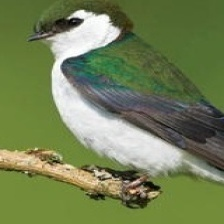

In [25]:
import random
from PIL import Image

image_path_list = list(data_path.glob('*/*/*.jpg'))
random_image_path = random.choice(image_path_list)

# Turn the image into an array
img = Image.open(random_image_path)
img

### 3.3 Creating a transform 

In [27]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### 3.4 Create Datasets with ImageFolder

In [28]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_path, # target folder of images
                                  transform=auto_transforms, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_path, 
                                 transform=auto_transforms)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 84635
    Root location: data/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 2625
    Root location: data/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )


In [30]:
# Get class names as a list
class_names = train_data.classes
len(class_names), class_names

(525,
 ['ABBOTTS BABBLER',
  'ABBOTTS BOOBY',
  'ABYSSINIAN GROUND HORNBILL',
  'AFRICAN CROWNED CRANE',
  'AFRICAN EMERALD CUCKOO',
  'AFRICAN FIREFINCH',
  'AFRICAN OYSTER CATCHER',
  'AFRICAN PIED HORNBILL',
  'AFRICAN PYGMY GOOSE',
  'ALBATROSS',
  'ALBERTS TOWHEE',
  'ALEXANDRINE PARAKEET',
  'ALPINE CHOUGH',
  'ALTAMIRA YELLOWTHROAT',
  'AMERICAN AVOCET',
  'AMERICAN BITTERN',
  'AMERICAN COOT',
  'AMERICAN DIPPER',
  'AMERICAN FLAMINGO',
  'AMERICAN GOLDFINCH',
  'AMERICAN KESTREL',
  'AMERICAN PIPIT',
  'AMERICAN REDSTART',
  'AMERICAN ROBIN',
  'AMERICAN WIGEON',
  'AMETHYST WOODSTAR',
  'ANDEAN GOOSE',
  'ANDEAN LAPWING',
  'ANDEAN SISKIN',
  'ANHINGA',
  'ANIANIAU',
  'ANNAS HUMMINGBIRD',
  'ANTBIRD',
  'ANTILLEAN EUPHONIA',
  'APAPANE',
  'APOSTLEBIRD',
  'ARARIPE MANAKIN',
  'ASHY STORM PETREL',
  'ASHY THRUSHBIRD',
  'ASIAN CRESTED IBIS',
  'ASIAN DOLLARD BIRD',
  'ASIAN GREEN BEE EATER',
  'ASIAN OPENBILL STORK',
  'AUCKLAND SHAQ',
  'AUSTRAL CANASTERO',
  'AUSTRALASIAN 

In [31]:
# Check the lengths
len(train_data), len(test_data)

(84635, 2625)

In [42]:
# Get the first image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[ 1.7180,  1.7009,  1.6838,  ...,  2.1633,  2.1804,  2.1290],
         [ 1.7180,  1.7009,  1.7009,  ...,  2.1804,  2.1290,  2.0605],
         [ 1.7352,  1.7352,  1.7352,  ...,  2.1633,  2.0605,  2.0092],
         ...,
         [ 1.4269,  1.2728,  1.0502,  ..., -1.3473, -1.3302, -1.3644],
         [ 0.8789,  0.5707,  0.2967,  ..., -1.3302, -1.3302, -1.3644],
         [-0.1999, -0.1828, -0.0116,  ..., -1.3130, -1.3302, -1.4158]],

        [[ 1.7808,  1.7633,  1.7283,  ...,  2.1835,  2.2185,  2.1660],
         [ 1.7458,  1.7283,  1.7108,  ...,  2.2010,  2.1660,  2.1134],
         [ 1.7108,  1.7108,  1.6933,  ...,  2.2010,  2.1485,  2.1310],
         ...,
         [ 1.4482,  1.2906,  1.0805,  ..., -1.2129, -1.2304, -1.2654],
         [ 0.8004,  0.4678,  0.2227,  ..., -1.1954, -1.2129, -1.2479],
         [-0.3550, -0.3550, -0.1450,  ..., -1.2129, -1.2479, -1.3354]],

        [[ 1.7511,  1.7337,  1.7163,  ...,  2.2217,  2.2391,  2.1520],
         [ 1.7685,  1.7511,  1.

### 3.5 Turn loaded images into Dataloaders

In [47]:
# Batchsize
batch_size = 32

# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=batch_size, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=batch_size, 
                             num_workers=1, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f0b018527a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f0b01852290>)

## 4. Getting a pretrained model

### 4.1 Setting up pretrained model

In [48]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### 4.2 Model summary

In [49]:
from torchinfo import summary
summary(model, 
        input_size=(batch_size, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112